In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [3]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn, bilstm

model_name = 'cnn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Unnamed: 0,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,...,rcmod,rel,root,tmod,xcomp,xsubj,Answer.1gamemove.yes_pc_agree,Answer.2reasoning.yes_pc_agree,Answer.4shareinformation.yes_pc_agree,Answer.3rapport.yes_pc_agree
0,5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.8,1.0,0.8
1,6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.6,0.8,0.8
2,7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,...,0.0,0.0,1.0,0.0,1.0,0.0,0.8,0.6,0.6,0.6
3,8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.8,0.8,0.8,0.8
4,9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,...,0.0,0.0,1.0,0.0,2.0,1.0,0.8,0.8,1.0,1.0


In [6]:
###################################
# pipeline-onehot Function blocks #
###################################

def sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state):
    y = dataframe[class_name].copy()
    X = dataframe.drop([class_name], axis=1)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    splits_generator = sss.split(X, y)

    for train_idx, test_idx in splits_generator:
        indices_train = train_idx
        indices_test = test_idx

    train = df.take(indices_train)
    test = df.take(indices_test)
    
    return indices_train, indices_test, train, test

def generate_class_weights(train_data, class_name, annotation_name):
    # Check if first class label is numeric or alphabetic
    if class_name == annotation_name:
        ## Convert to int type
        tmp_y_train = train_data[annotation_name].copy()
        tmp_y_train[annotation_name] = train_data[annotation_name].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_train = tmp_y_train[annotation_name].to_numpy()
    else:
        y_train = train_data[annotation_name].to_numpy()
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return y_train, class_weight_dict

def label_preprocessing(y_data, label_encoder):
    out = label_encoder.fit_transform(y_data).reshape(-1,1)
    return out

def individual_model(annot_name, x_train_data, y_train_data, x_val_data, y_val_data, class_weight_dict, indiv_batch_size, indiv_epochs):
    model = models_nn.create_nn_model()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(),
                  metrics = ['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
    history = model.fit(x_train_data,y_train_data,
                        batch_size=indiv_batch_size,
                        epochs=indiv_epochs,
                        validation_data=(x_val_data, y_val_data), 
#                         callbacks=[models_nn.early_stop],
                        class_weight=class_weight_dict,
                        verbose=0)
    
    pred = model.predict(x_train_data)
    pred_test = model.predict(x_val_data)

    pred_test_round = pred_test.round()
    
    validation_metrics_dict = history.history
    val_f1_list = history.history['val_f1_m']
    best_val_f1 = max(val_f1_list)
    best_val_prec = history.history['val_precision_m'][val_f1_list.index(best_val_f1)]
    best_val_recall = history.history['val_recall_m'][val_f1_list.index(best_val_f1)]
    macro_scores = precision_recall_fscore_support(y_val_data, pred_test_round, average='macro')
    print("#############################################################")
    print("Metrics for {} individual model:".format(annot_name))
    print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                 best_val_prec,
                                                                                 best_val_recall))
    print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                  macro_scores[0],
                                                                                  macro_scores[1]))
    return pred, pred_test

# (HARD-CODED)
def generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred):
    pred_df_arr_full = []
    pred_df_arr = []
    for i in range(0, len(gamemove_pred)):
        pred_obj_1 = {}
        pred_obj_1['gamemove'] = gamemove_pred[i][0]
        pred_obj_1['reasoning'] = reasoning_pred[i][0]
        pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
        pred_df_arr.append(pred_obj_1)

        pred_obj_2 = pred_obj_1.copy()
        pred_obj_2['rapport'] = rapport_pred[i][0]
        pred_df_arr_full.append(pred_obj_2)

    pred_df_full = pd.DataFrame(pred_df_arr_full)
    pred_df = pd.DataFrame(pred_df_arr)
    return pred_df_full, pred_df

def joint_model(is_max, weights_name, pred_df_full, y_train_1, pred_df_full_test, y_test_1,
                pred_df, y_train_2, pred_df_test, y_test_2,
                class_weight_dict_1, class_weight_dict_2, joint_batch_size, joint_epochs):
    def helper(predict_name, pred_df, y_train, pred_df_test, y_test, class_weight_dict_1, joint_batch_size, joint_epochs):
        joint_full_model_1 = models_nn.create_joint_model(pred_df_full)
        history_1 = joint_full_model_1.fit(x=pred_df_full, 
                                           y=y_train_1, 
                                           epochs=joint_epochs, 
                                           batch_size=joint_batch_size, 
                                           validation_data=(pred_df_full_test,y_test_1), 
                                           #callbacks=[models_nn.callback], 
                                           class_weight=class_weight_dict_1,
                                           verbose=0)
        joint_predict_1 = joint_full_model_1.predict(pred_df_full_test)
        # joint_predict_round = []
        # for a in joint_predict:
        #     joint_predict_round.append(np.argmax(a))
        joint_predict_round_1 = joint_predict_1.round()
        out1 = precision_recall_fscore_support(y_test_1, np.array(joint_predict_round_1), average='macro')

        val_f1_list = history_1.history['val_f1_m']
        
        # if is_max, then take max f1 from history, otherwise take last value
        if is_max == True:
            best_val_f1 = max(val_f1_list)
        else:
            best_val_f1 = val_f1_list[-1]
        
        best_val_prec = history_1.history['val_precision_m'][val_f1_list.index(best_val_f1)]
        best_val_recall = history_1.history['val_recall_m'][val_f1_list.index(best_val_f1)]
        macro_scores = out1
        if weights_name == None:
            print("Metrics for {} joint model w/o weights:".format(predict_name))
        else:
            print("Metrics for {} joint model weighted by {}".format(predict_name, weights_name))
        print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                     best_val_prec,
                                                                                     best_val_recall))
        print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                      macro_scores[0],
                                                                                      macro_scores[1]))
        return [best_val_f1, best_val_prec, best_val_recall], macro_scores
    
    print("#############################################################")
    decep_1, decep_2 = helper("Deception", pred_df_full, y_train_1, pred_df_full_test, y_test_1, class_weight_dict_1, joint_batch_size, joint_epochs)
    rapport_1, rapport_2 = helper("Rapport", pred_df, y_train_2, pred_df_test, y_test_2, class_weight_dict_2, joint_batch_size, joint_epochs)

    
    return decep_1, decep_2, rapport_1, rapport_2

In [7]:
##################################################
# Main function for dataset sampling experiments #
##################################################

# Currently only supports annotations with 2 classes, i.e. binary

def dataset_sampling(dataframe, class_name, sampling_size_list, metadata_options_list, model_name, is_drop_rapport):
    
    # Misc variables
    results = {}
    
    # Model settings (for individual annotation models)
    models_nn.MODEL_NAME = model_name
    
    # Full dataframe proportions
    full_size = dataframe.shape[0]
    full_counts = dataframe[class_name].value_counts()
    print("Full dataset proportions w.r.t. {}".format(class_name))
    print(full_counts)
    full_counts_dict = full_counts.to_dict()
    full_counts_list = list(full_counts_dict.values())
    
    ## class_proportions is a list of class proportions, first item corresponding to first class, etc
    class_proportions = []
    for each_class_counts in full_counts_list:
        class_proportions.append(each_class_counts / full_size)

    # Looping through sample_size_list
    for each_sample_size in sampling_size_list:
        
        print("#################################")
        print("Sample size: {}".format(each_sample_size))
        print("#################################")
        
        ## Counting number of datapoints per class proportionate to main dataset
        class_sizes = [round(each_sample_size * class_proportions[0])]
        class_sizes.append(each_sample_size - class_sizes[0])

        ## Creating sub dataframe
        s0 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[0]].sample(class_sizes[0]).index
        s1 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[1]].sample(class_sizes[1]).index
        sub_df = dataframe.loc[s0.union(s1)]

        # Metadata settings
        print("#############################################################")
        print("Metadata options for current sample")
        df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(sub_df, *metadata_options_list)
  
        ## Train_test_split using SSS
        indices_train, indices_test, train, test = sss_train_test_split(sub_df, class_name, n_splits, test_size, random_state)
        
        ## Generate class weights dict and y_train data (HARD-CODED)
        y_train_deception, deception_class_weight_dict = generate_class_weights(train, class_name, "Input.deception_quadrant")
        y_train_rapport, rapport_class_weight_dict = generate_class_weights(train, class_name, 'Answer.3rapport.yes_label')
        y_train_share_information, share_info_class_weight_dict = generate_class_weights(train, class_name, 'Answer.4shareinformation.yes_label')
        y_train_reasoning, reasoning_class_weight_dict = generate_class_weights(train, class_name, 'Answer.2reasoning.yes_label')
        y_train_gamemove, gamemove_class_weight_dict = generate_class_weights(train, class_name, 'Answer.1gamemove.yes_label')
        print("#############################################################")
        print("Class weights generated")
        print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                          rapport_class_weight_dict,
                                                                                                          share_info_class_weight_dict,
                                                                                                          reasoning_class_weight_dict,
                                                                                                          gamemove_class_weight_dict))
        
        ## Train and test data preparation (HARD-CODED)
        X_train_col = train['Input.full_text']
        
        new_deception_test = test["Input.deception_quadrant"].copy()
        new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
        y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
        y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
        y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
        y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()
        X_test_col = test['Input.full_text']
        
        le = LabelEncoder()

        y_train_deception = label_preprocessing(y_train_deception, le)
        y_train_rapport = label_preprocessing(y_train_rapport, le)
        y_train_share_information = label_preprocessing(y_train_share_information, le)
        y_train_reasoning = label_preprocessing(y_train_reasoning, le)
        y_train_gamemove = label_preprocessing(y_train_gamemove, le)
        
        y_test_deception = label_preprocessing(y_test_deception, le)
        y_test_rapport = label_preprocessing(y_test_rapport, le)
        y_test_share_information = label_preprocessing(y_test_share_information, le)
        y_test_reasoning = label_preprocessing(y_test_reasoning, le)
        y_test_gamemove = label_preprocessing(y_test_gamemove, le)
        
        ## Tokenizer settings
        max_words = 1000
        max_len = 220

        tok = Tokenizer(num_words=max_words)

        tok.fit_on_texts(X_train_col)
        X_train_sequences = tok.texts_to_sequences(X_train_col)
        X_train = pad_sequences(X_train_sequences, maxlen=max_len)

        X_test_sequences = tok.texts_to_sequences(X_test_col)
        X_test = pad_sequences(X_test_sequences, maxlen=max_len)
        
        ## Individual Models (HARD-CODED)
        ### Deception pred and pred_test not needed
        _, _ = individual_model('Deception', X_train, y_train_deception, X_test, y_test_deception, deception_class_weight_dict, indiv_batch_size, indiv_epochs)
        rapport_pred, rapport_pred_test = individual_model('Rapport', X_train, y_train_rapport, X_test, y_test_rapport, rapport_class_weight_dict, indiv_batch_size, indiv_epochs)
        shareinfo_pred, shareinfo_pred_test = individual_model('Share Info', X_train, y_train_share_information, X_test, y_test_share_information, share_info_class_weight_dict, indiv_batch_size, indiv_epochs)
        reasoning_pred, reasoning_pred_test = individual_model('Reasoning', X_train, y_train_reasoning, X_test, y_test_reasoning, reasoning_class_weight_dict, indiv_batch_size, indiv_epochs)
        gamemove_pred, gamemove_pred_test = individual_model('Gamemove', X_train, y_train_gamemove, X_test, y_test_gamemove, gamemove_class_weight_dict, indiv_batch_size, indiv_epochs)
        
        ## Generate one-hot encodings (HARD-CODED)
        pred_df_full, pred_df = generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred)
        pred_test_df_full, pred_test_df = generate_encodings(gamemove_pred_test, reasoning_pred_test, shareinfo_pred_test, rapport_pred_test)
        
        if is_drop_rapport:
            pred_df_full, pred_test_df_full = pred_df.copy(), pred_test_df.copy()
            
        ## Generate weighted one-hot encodings (HARD-CODED)
        pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)
        pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)
        print("#############################################################")
        print("Weighted one-hot encodings generated")
        
        ## Joint model w/o weights
        out1_wo_weights, _, out2_wo_weights, _ = joint_model(False, None, pred_df_full, y_train_deception, pred_test_df_full, y_test_deception,
                                                             pred_df, y_train_rapport, pred_test_df, y_test_rapport,
                                                             deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Throughput
        out1_tp, _, out2_tp, _ = joint_model(False, 'Throughput', pred_df_full_throughput, y_train_deception, pred_df_full_throughput_test, y_test_deception,
                                       pred_df_throughput, y_train_rapport, pred_df_throughput_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Worktime
        out1_wt, _, out2_wt, _ = joint_model(False, 'Worktime', pred_df_full_worktime, y_train_deception, pred_df_full_worktime_test, y_test_deception,
                                       pred_df_worktime, y_train_rapport, pred_df_worktime_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by PC Agreement
        out1_pc, _, out2_pc, _ = joint_model(False, 'PC Agreement', pred_df_full_agreement, y_train_deception, pred_df_full_agreement_test, y_test_deception,
                                       pred_df_agreement, y_train_rapport, pred_df_agreement_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Text Length
        out1_tl, _, out2_tl, _ = joint_model(False, 'Text Length', pred_df_full_textlength, y_train_deception, pred_df_full_textlength_test, y_test_deception,
                                       pred_df_textlength, y_train_rapport, pred_df_textlength_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Special options
        out1_sp, _, out2_sp, _ = joint_model(False, 'Special', pred_df_full_special, y_train_deception, pred_df_full_special_test, y_test_deception,
                                       pred_df_special, y_train_rapport, pred_df_special_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        results['run_' + str(each_sample_size)] = [out1_wo_weights, out2_wo_weights, out1_tp, out2_tp, out1_wt, out2_wt, 
                                                   out1_pc, out2_pc, out1_tl, out2_tl, out1_sp, out2_sp]
    print("Done")
    return results

In [8]:
####################################
# Arguments for current experiment #
####################################

# Metadata options
throughput_option = 'TP2'
worktime_option = 'WT1'
pc_agreement_option = 'PC1'
textlength_option = 'TL2'
special_option = 'SP1'
k_option_for_tp = 3
metadata_options_choices = [throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp]

# Train_test_split SSS options
n_splits = 1
test_size = 0.2
random_state = 0

# Individual model options
model_name = 'lstm-attn'
indiv_batch_size = 128
indiv_epochs = 50

# Joint model options
joint_batch_size = 64
joint_epochs = 32

Full dataset proportions w.r.t. Input.deception_quadrant
Straightforward    10808
Cassandra            558
Name: Input.deception_quadrant, dtype: int64
#################################
Sample size: 250
#################################
#############################################################
Metadata options for current sample
TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights generated
Deception: {0: 100.0, 1: 0.5025125628140703} 
Rappo

Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.07407407407407407, Precision = 0.5, Recall = 0.04
#################################
Sample size: 500
#################################
#############################################################
Metadata options for current s

Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macr

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.99454265832901, Precision = 0.9891493320465088, Recall = 1.0
Macro validation metrics: F1 = 0.494949494949495, Precision = 0.494949494949495, Recall = 0.494949494949495
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9106013774871826, Precision = 0.8425351977348328, Recall = 0.9906542301177979
Macro validation metrics: F1 = 0.4802494802494803, Precision = 0.5031116934163118, Recall = 0.5051714752313554
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.8453637361526489, Precision = 0.7322048544883728, Recall = 1.0
Macro validation metrics: F1 = 0.5426829268292682, Precision = 0.615295143937191, Recall = 0.5508920549351817
#############################################################
Metric

Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.0477072075009346, Precision = 0.9999999403953552, Recall = 0.024506106972694397
Macro validation metrics: F1 = 0.039938556067588324, Precision = 0.5081967213114754, Recall = 0.5121951219512195
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9919354915618896, Precision = 0.984375, Recall = 1.0
Macro validation metrics: F1 = 0.4959677419354839, Precision = 0.492, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9386265873908997, Precision = 0.982758641242981, Recall = 0.8987607955932617
Macro validation metrics: F1 = 0.46921443736730356, Precision = 0.4911111111111111, Recall = 0.4491869918699187
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9919354915618896, Precision = 0.984375, Recall = 1.0
Macro validation me

Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.7696689367294312, Precision = 0.9941176176071167, Recall = 0.6313233375549316
Macro validation metrics: F1 = 0.410734193342889, Precision = 0.510600539491742, Recall = 0.6891891891891893
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9936507940292358, Precision = 0.987500011920929, Recall = 1.0
Macro validation metrics: F1 = 0.4966442953020134, Precision = 0.49333333333333335, Recall = 0.5
#################################
Sample size: 1750
#################################
#############################################################
Metadata options for current sample
TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.8899883031845093, Precision = 0.8024114370346069, Recall = 1.0
Macro validation metrics: F1 = 0.5486611917306881, Precision = 0.5468720821661999, Recall = 0.552022881777483
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9127904176712036, Precision = 0.83984375, Recall = 1.0
Macro validation metrics: F1 = 0.5355857424822943, Precision = 0.5349047420386595, Recall = 0.5444720056697379
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9625012874603271, Precision = 0.9366016387939453, Recall = 0.9912803173065186
Macro validation metrics: F1 = 0.4886000426166631, Precision = 0.49055158324821246, Recall = 0.4881067180970749
#############################################################
Weighte

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.49458155035972595, Precision = 0.9767315983772278, Recall = 0.33875060081481934
Macro validation metrics: F1 = 0.2677801724137931, Precision = 0.5040470093286995, Recall = 0.533675799086758
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9880308508872986, Precision = 0.9765625, Recall = 1.0
Macro validation metrics: F1 = 0.49324324324324326, Precision = 0.4866666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.5847951769828796, Precision = 0.9845008254051208, Recall = 0.41744402050971985
Macro validation metrics: F1 = 0.3195890513340884, Precision = 0.5084413317176364, Recall = 0.5781963470319634
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9880308508872986, Precision = 0.9765625, Recall = 1.0
M

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.9853865504264832, Precision = 0.9712993502616882, Recall = 1.0
Macro validation metrics: F1 = 0.4907407407407407, Precision = 0.48534798534798534, Recall = 0.49625468164794007
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9265331029891968, Precision = 0.863897979259491, Recall = 1.0
Macro validation metrics: F1 = 0.47028496969010253, Precision = 0.47210850152026623, Recall = 0.4690159574468085
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9132140874862671, Precision = 0.8402960896492004, Recall = 1.0
Macro validation metrics: F1 = 0.5197510822510822, Precision = 0.5197510822510822, Recall = 0.5197510822510822
#############################################################
Metrics for 

Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.8707256317138672, Precision = 0.9808939099311829, Recall = 0.7871881723403931
Macro validation metrics: F1 = 0.44823388531997804, Precision = 0.496972606976025, Recall = 0.4736394557823129
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9904499053955078, Precision = 0.981249988079071, Recall = 1.0
Macro validation metrics: F1 = 0.494949494949495, Precision = 0.49, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.7687416672706604, Precision = 0.9750006794929504, Recall = 0.6349566578865051
Macro validation metrics: F1 = 0.39354559237600173, Precision = 0.49160879629629634, Recall = 0.4013605442176871
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9904499053955078, Precision = 0.981249988079071, Recall = 1.0
Macro

Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.5083987712860107, Precision = 0.9821661114692688, Recall = 0.3454894721508026
Macro validation metrics: F1 = 0.2791462758928652, Precision = 0.5036838156193783, Recall = 0.5396593673965937
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9891476035118103, Precision = 0.9786931872367859, Recall = 1.0
Macro validation metrics: F1 = 0.49458483754512633, Precision = 0.48928571428571427, Recall = 0.5
#################################
Sample size: 4000
#################################
#############################################################
Metadata options for current sample
TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC1: weighted by 1 average per set of OHE, i.e. (a, b, 

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9268896579742432, Precision = 0.865234375, Recall = 1.0
Macro validation metrics: F1 = 0.49792094411566795, Precision = 0.5044444444444445, Recall = 0.5064190345771996
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9049441814422607, Precision = 0.828125, Recall = 1.0
Macro validation metrics: F1 = 0.5126705653021443, Precision = 0.5249671746309633, Recall = 0.540123315825531
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9710151553153992, Precision = 0.9443359375, Recall = 1.0
Macro validation metrics: F1 = 0.5233231188287368, Precision = 0.5255235051719788, Recall = 0.5568458512830118
#############################################################
Weighted one-hot encodings generated


Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9808748960494995, Precision = 0.962890625, Recall = 1.0
Macro validation metrics: F1 = 0.49031600407747195, Precision = 0.481, Recall = 0.5
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9808748960494995, Precision = 0.962890625, Recall = 1.0
Macro validation metrics: F1 = 0.49031600407747195, Precision = 0.481, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.49595901370048523, Precision = 0.9543445110321045, Recall = 0.33683058619499207
Macro validation metrics: F1 = 0.27974409472629724, Precision = 0.49304263228593487, Recall = 0.4573531020899442
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9808748960494995, Precision = 0.962890625, Recall = 1.0
Macro validation metrics: F1 = 0.49031600407747195, Preci

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.9864500761032104, Precision = 0.973437488079071, Recall = 1.0
Macro validation metrics: F1 = 0.4906903360336588, Precision = 0.49385964912280705, Recall = 0.48940571082635453
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9197918772697449, Precision = 0.8518229722976685, Recall = 1.0
Macro validation metrics: F1 = 0.3840376045194982, Precision = 0.4758251388221812, Recall = 0.4526869544185228
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.903659462928772, Precision = 0.8247395753860474, Recall = 1.0
Macro validation metrics: F1 = 0.46190797648048687, Precision = 0.5045135293323129, Recall = 0.5078334082162881
#############################################################
Metrics for Re

Metrics for Rapport joint model w/o weights:
Best validation metrics: F1 = 0.9859153032302856, Precision = 0.972470223903656, Recall = 1.0
Macro validation metrics: F1 = 0.49278189621537266, Precision = 0.4857692307692308, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.663129985332489, Precision = 0.9711896777153015, Recall = 0.5055922865867615
Macro validation metrics: F1 = 0.358308012154166, Precision = 0.49817344138794784, Recall = 0.48349061650724356
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9859153032302856, Precision = 0.972470223903656, Recall = 1.0
Macro validation metrics: F1 = 0.49278189621537266, Precision = 0.4857692307692308, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.37056493759155273, Precision 

Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9824246764183044, Precision = 0.9656047224998474, Recall = 1.0
Macro validation metrics: F1 = 0.49127906976744184, Precision = 0.4828571428571429, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.43223774433135986, Precision = 0.978284478187561, Recall = 0.2801113426685333
Macro validation metrics: F1 = 0.2546085447842117, Precision = 0.5076708365592274, Recall = 0.5464127218934911
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9824246764183044, Precision = 0.9656047224998474, Recall = 1.0
Macro validation metrics: F1 = 0.49127906976744184, Precision = 0.4828571428571429, Recall = 0.5
#################################
Sample size: 7500
#################################
#############################################################
Metadata options for cu

#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9265950918197632, Precision = 0.8635817170143127, Recall = 1.0
Macro validation metrics: F1 = 0.47753137967388515, Precision = 0.5022053753580847, Recall = 0.5041033067825247
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9174655079841614, Precision = 0.8479567170143127, Recall = 1.0
Macro validation metrics: F1 = 0.48160101673090905, Precision = 0.506073537652485, Recall = 0.5107551012307683
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9097779989242554, Precision = 0.8353365659713745, Recall = 1.0
Macro validation metrics: F1 = 0.5023762810721917, Precision = 0.51480587610466, Recall = 0.52295952669087
#############################################################
Metrics for Gamemo

Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9811229109764099, Precision = 0.9632201790809631, Recall = 1.0
Macro validation metrics: F1 = 0.49071300179748356, Precision = 0.48176470588235293, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.4779210388660431, Precision = 0.9604781270027161, Recall = 0.32276082038879395
Macro validation metrics: F1 = 0.2780073682887246, Precision = 0.5002254485717124, Recall = 0.5014080901177675
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9811229109764099, Precision = 0.9632201790809631, Recall = 1.0
Macro validation metrics: F1 = 0.49071300179748356, Precision = 0.48176470588235293, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.92258465290069

Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.609948992729187, Precision = 0.9511584639549255, Recall = 0.45246437191963196
Macro validation metrics: F1 = 0.33834527925302943, Precision = 0.4916555958895002, Recall = 0.44674032886230775
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.979724645614624, Precision = 0.9606680870056152, Recall = 1.0
Macro validation metrics: F1 = 0.48965126169549195, Precision = 0.4797222222222222, Recall = 0.5
#################################
Sample size: 9500
#################################
#############################################################
Metadata options for current sample
TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC1: weighted by 1 average per set of OHE, i.e. (a, b, 

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.8033148646354675, Precision = 0.8607034087181091, Recall = 0.7545469999313354
Macro validation metrics: F1 = 0.4857672880712429, Precision = 0.49416345598742206, Recall = 0.4914008915806555
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.8168443441390991, Precision = 0.8398922681808472, Recall = 0.797157883644104
Macro validation metrics: F1 = 0.4574652777777778, Precision = 0.49650798755967346, Recall = 0.49377726750861073
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9660624861717224, Precision = 0.9345703125, Recall = 1.0
Macro validation metrics: F1 = 0.4886811465514661, Precision = 0.49995268656799496, Recall = 0.49989584992586966
################################################

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.7934960722923279, Precision = 0.9588442444801331, Recall = 0.6801651120185852
Macro validation metrics: F1 = 0.4342929655543451, Precision = 0.49977925197657985, Recall = 0.49880263871317554
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9784114956855774, Precision = 0.9581148028373718, Recall = 1.0
Macro validation metrics: F1 = 0.4892996108949416, Precision = 0.47904761904761906, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.05602044612169266, Precision = 0.8181817531585693, Recall = 0.02921145223081112
Macro validation metrics: F1 = 0.06842862987614427, Precision = 0.4966602298268385, Recall = 0.49761657328754744
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9784114956855774, Precision = 0.9581148028

Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.975432276725769, Precision = 0.952380895614624, Recall = 1.0
Macro validation metrics: F1 = 0.48777648428405124, Precision = 0.47613636363636364, Recall = 0.5
#################################
Sample size: 11366
#################################
#############################################################
Metadata options for current sample
TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
############################################

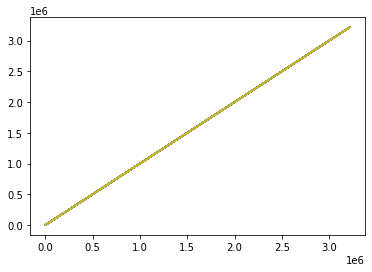

In [9]:
sampling_sizes = [250, 500, 750, 
                  1000, 1250, 1500, 1750, 
                  2000, 2250, 2500, 2750,
                  3000, 3500, 
                  4000, 4500, 
                  5000, 5500, 
                  6000, 6500, 
                  7000, 7500, 
                  8000, 8500, 
                  9000, 9500, 
                  10000, 10500, 11000, 11366]
# sampling_sizes = [11366]

results_dict = dataset_sampling(dataframe=df, 
                                class_name="Input.deception_quadrant", 
                                sampling_size_list=sampling_sizes, 
                                metadata_options_list=metadata_options_choices, 
                                model_name=model_name,
                                is_drop_rapport=False)

In [10]:
def translate_into_pandas(results_dictionary, metric_of_focus):
    def helper(metric_of_focus_number):
        new_dict = {}
        for each_key, each_values_list in results_dictionary.items():
            new_dict[each_key[4:]] = []
            for each in each_values_list:
                new_dict[each_key[4:]].append(each[metric_of_focus_number])
        out_df = pd.DataFrame.from_dict(new_dict)
        return out_df
    
    if metric_of_focus == 'F1':
        metric_of_focus_number = 0
    elif metric_of_focus == 'Precision':
        metric_of_focus_number = 1
    elif metric_of_focus == 'Recall':
        metric_of_focus_number = 2
        
    return helper(metric_of_focus_number)

metric_of_focus = ['Precision', 'Recall', 'F1']

for metric in metric_of_focus:
    experiment_df = translate_into_pandas(results_dict, metric)
    results_name = "./output/dataset_sampling_" + str(len(sampling_sizes)) + '_' + str(metric) + "_pts_last_cnn"
    experiment_df.to_csv(results_name + ".csv", index=False)

In [11]:
experiment_df.head()

,250,500,750,1000,1250,1500,1750,2000,2250,2500,...,7000,7500,8000,8500,9000,9500,10000,10500,11000,11366
0,0.0,0.0,0.715451,1.000000,0.232337,0.363948,0.759953,0.814968,0.267196,0.590395,...,0.625431,0.274481,0.089495,0.018717,0.610284,0.402149,0.015014,0.662653,0.076747,0.693357
1,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.0,0.0,0.584724,0.705171,0.024506,0.654921,0.760249,0.361283,1.000000,0.639415,...,0.505051,0.110776,0.000000,0.000000,0.000556,0.598741,0.639093,0.389254,0.000000,0.689338
3,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.0,0.0,0.989501,0.090402,0.898761,1.000000,0.552487,0.760829,0.338751,0.031051,...,1.000000,0.611200,0.478621,0.322761,0.015303,0.762002,0.488950,0.680165,0.869774,0.137509


In [12]:
exp_plot_df = experiment_df.T.reset_index()
rename_col_names = {0: 'Deception w/o weights',
                    1: 'Rapport w/o weights',
                    2: 'Deception by TP',
                    3: 'Rapport by TP',
                    4: 'Deception by WT',
                    5: 'Rapport by WT',
                    6: 'Deception by PC',
                    7: 'Rapport by PC',
                    8: 'Deception by TL',
                    9: 'Rapport by TL',
                    10: 'Deception by SP',
                    11: 'Rapport by SP'}
exp_plot_df = exp_plot_df.rename(columns=rename_col_names)

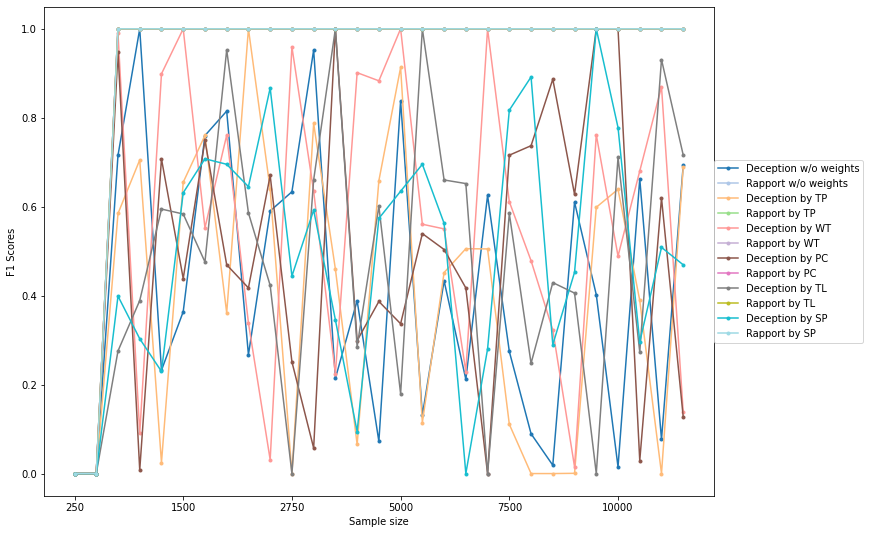

In [13]:
plot = exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9), colormap='tab20')
plot.set_xlabel('Sample size', size=10)
plot.set_ylabel('F1 Scores', size=10)
lgd = plot.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)
plot = plot.get_figure()
plot.savefig(results_name + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [30]:
experiment_df = pd.read_csv("/home/kaiyuan/Desktop/ky_code/affcon/diplomacy-betrayal/output/dataset_sampling_29_F1_pts_last_cnn.csv")

predict_option = "d"

if predict_option == "rapport":
    row_names = [0,2,4,6,8,10]
else:
    row_names = [1,3,5,7,9,11]

experiment_df = experiment_df.drop(row_names)
experiment_df

,250,500,750,1000,1250,1500,1750,2000,2250,2500,...,7000,7500,8000,8500,9000,9500,10000,10500,11000,11366
0,0.0,0.0,0.831340,0.996063,0.375823,0.530826,0.852441,0.890285,0.406712,0.729712,...,0.755320,0.425261,0.162136,0.036091,0.744874,0.562523,0.029006,0.780829,0.139665,0.801131
2,0.0,0.0,0.737161,0.816977,0.047707,0.786579,0.857057,0.527194,0.988031,0.769488,...,0.660525,0.196520,0.000000,0.000000,0.001095,0.732898,0.763081,0.550569,0.000000,0.796217
4,0.0,0.0,0.992084,0.164618,0.938627,0.993651,0.706634,0.858826,0.494582,0.059795,...,0.982425,0.748222,0.634833,0.477921,0.029544,0.846316,0.640832,0.793496,0.909036,0.237782
6,0.0,0.0,0.970743,0.015152,0.820652,0.605066,0.850019,0.636499,0.584795,0.790268,...,0.000000,0.822597,0.831312,0.922585,0.754300,0.975725,0.972856,0.056020,0.746504,0.221972
8,0.0,0.0,0.425151,0.552973,0.742651,0.733579,0.632727,0.969987,0.723284,0.584696,...,0.000000,0.727067,0.389079,0.592895,0.567625,0.000000,0.810365,0.422822,0.940234,0.815559
10,0.0,0.0,0.566667,0.460104,0.368289,0.769669,0.823456,0.816932,0.770522,0.913238,...,0.432238,0.884646,0.922785,0.443972,0.609949,0.975725,0.852138,0.447745,0.661170,0.625476


In [31]:
exp_plot_df = experiment_df.T.reset_index()
rename_col_names = {0: 'Deception w/o weights',
                    1: 'Rapport w/o weights',
                    2: 'Deception by TP',
                    3: 'Rapport by TP',
                    4: 'Deception by WT',
                    5: 'Rapport by WT',
                    6: 'Deception by PC',
                    7: 'Rapport by PC',
                    8: 'Deception by TL',
                    9: 'Rapport by TL',
                    10: 'Deception by SP',
                    11: 'Rapport by SP'}
exp_plot_df = exp_plot_df.rename(columns=rename_col_names)

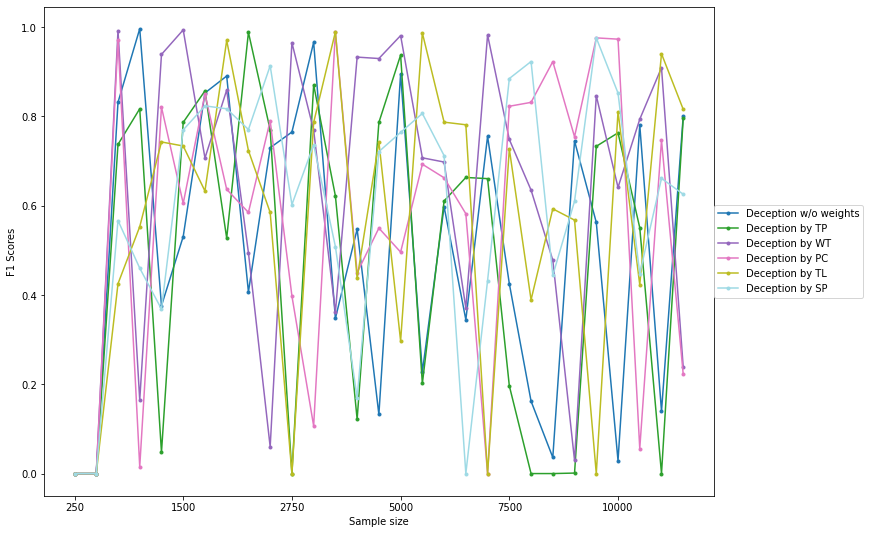

In [32]:
plot = exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9), colormap='tab20')
plot.set_xlabel('Sample size', size=10)
plot.set_ylabel('F1 Scores', size=10)
lgd = plot.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)
plot = plot.get_figure()
plot.savefig(results_name + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [17]:
results_dict

{'run_250': [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 'run_500': [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 'run_750': [[0.8313403725624084, 0.9929078221321106, 0.7154507040977478],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.7371606230735779, 1.0, 0.5847237706184387],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.992084264755249, 0.9947090148925781, 0.9895007014274597],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.9707426428794861, 0.994535505771637, 0.9481421113014221],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.42515072226524353, 0.9824561476707458, 0.27563580870628357],
  [0.997